### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras.datasets import boston_housing
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, Dense
import numpy as np
import matplotlib.pyplot as plt
import random

c:\users\danie\pycharmprojects\tensorflowtest\venv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\danie\pycharmprojects\tensorflowtest\venv\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\users\danie\pycharmprojects\tensorflowtest\venv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Data

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
mean = train_data.mean(axis=0)
train_data -= mean
test_data -= mean

std = train_data.std(axis=0)
train_data /= std
test_data /= std

### Network


In [9]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dropout(0.2, input_shape=(13,)))
    model.add(Dense(64, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))

    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

#### K-fold validation

In [20]:
k = 4
samples_per = len(train_data) // k
num_epochs = 200
val_mae_history = np.zeros((k, num_epochs))
train_mae_history = np.zeros((k, num_epochs))
for i in range(k):
    val_data = train_data[i * samples_per: (i + 1) * samples_per]
    val_targets = train_targets[i * samples_per:(i + 1) * samples_per]
    p_train_data = np.concatenate((train_data[:i * samples_per], train_data[(i + 1) * samples_per:]))
    p_train_targets = np.concatenate((train_targets[:i * samples_per], train_targets[(i + 1) * samples_per:]))
    print(val_data.shape, p_train_data.shape, train_data.shape)

    model = build_model()
    history = model.fit(p_train_data, p_train_targets, epochs=num_epochs, batch_size=1, validation_data=(val_data, val_targets), verbose=0)

    mae_history = np.array(history.history["mae"])
    train_mae_history[i] = mae_history
    mae_history = np.array(history.history["val_mae"])
    val_mae_history[i] = mae_history

(101, 13) (303, 13) (404, 13)
(101, 13) (303, 13) (404, 13)
(101, 13) (303, 13) (404, 13)
(101, 13) (303, 13) (404, 13)


#### Validation Analysis

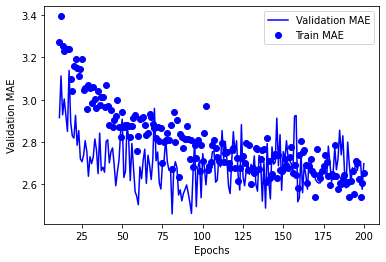

In [23]:
def smooth(samples: list, factor: int = 0.1):
    smoothened = []
    for val in samples:
        if len(smoothened) > 0:
            smoothened.append(smoothened[-1] * factor + (1 - factor) * val)
        else:
            smoothened.append(val)
    return smoothened

average_val_smoothed = smooth([np.mean(val_mae_history[:,i]) for i in range(num_epochs)])
average_train_smoothed = smooth([np.mean(train_mae_history[:,i]) for i in range(num_epochs)])
epochs = range(1, num_epochs + 1)
plt.plot(epochs[10:], average_val_smoothed[10:], "b", label="Validation MAE")
plt.plot(epochs[10:], average_train_smoothed[10:], "bo", label="Train MAE")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

#### Post analysis training

In [28]:
model = build_model()
history = model.fit(train_data, train_targets, epochs=300, batch_size=1, verbose=0)
test_mse, test_mae = model.evaluate(test_data, test_targets)
print("EVALUATION")
print("Mean Squared Error:", test_mse)
print("Mean Absolute Error:", test_mae)

4/4 [==============================] - 0s 1ms/step - loss: 26.5385 - mae: 3.7871
EVALUATION
Mean Squared Error: 26.538501739501953
Mean Absolute Error: 3.78707218170166


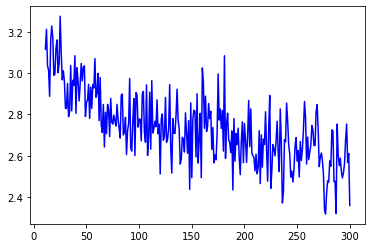

In [30]:
mae = np.array(history.history["mae"])
epochs = range(1, 301)
plt.plot(epochs[10:], mae[10:], "b")
plt.show()
